# LSTM

In [ ]:
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
# from google_drive_downloader import GoogleDriveDownloader as gdd

## Email spam classifier

In [ ]:
# Download data

# gdd.download_file_from_google_drive('13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ', '~/lingsmap_public-bare.zip', unzip=True)
!gdown 'https://drive.google.com/uc?id=13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ'
!unzip '/content/lingsmap_public-bare.zip'
assert Path('/content/lingsmap_public-bare').exists()

Unzipping...Done.


  0%|          | 0/2893 [00:00<?, ?it/s]

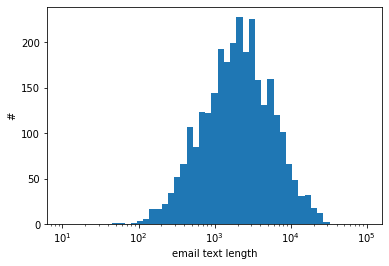

2893 emails
percentage spam: 0.17
ascii codes between 10 and 126


In [ ]:
# Load data

filepaths = glob.glob('~/lingsmap_public-bare/*/*.txt')
emails = []
emails_ascii = []
targets = []

for i, filepath in enumerate(tqdm(filepaths)):
    with open(filepath) as file:
        email = file.read()
    emails.append(email)
    emails_ascii.append([ord(c) for c in email])  # convert character to ascii code
    targets.append('spmsg' in filepath)

plt.hist([len(e) for e in emails], np.logspace(1, 5))
plt.xlabel('email text length')
plt.ylabel('#')
plt.xscale('log')
plt.show()

print(f'{len(emails)} emails')
print(f'percentage spam: {np.mean(targets):.2f}')
emails_ascii_flat = np.concatenate(emails_ascii)
print(f'ascii codes between {emails_ascii_flat.min()} and {emails_ascii_flat.max()}')

So even if we just guess 'not spam' all the time, we can get 83 % correct. Lets consider this as the **baseline**.

In [ ]:
# lets read few examples our loaded data
for i in range(4):
    print(f'----  Spam: {targets[i]}  ----')
    print(emails[i], '\n')

----  Spam: False  ----
Subject: grammar in schools

i 'd like to second herb stahlke 's plea , following his brief survey of the decline in grammar teaching ( which mirrors the events in uk ) . > i also teach an undergrad english linguistics course that , for many > students , is the only brush with grammar in the entire english ed . > program . i find that these students , many of them well prepared and > highly motivated , have had little or no grammar in k12 . this is not > surprising , since they were taught by teachers who were taught to > believe that the teaching of grammar served no purpose . if they were > taught it at all , little effort was made to make grammar make sense or > seem relevant and interesting . they will become teachers with > probablly less understanding of and ability to teach grammar than even > the generation before them . > > how do we reverse this ? certainly not by either replacing grammar > with even more abstract and difficulty linguistic subject matt

**Task**

* Create a class to load the dataset 
    * To be able to batch emails, they have to have the same length. You can ensure this in different ways e.g. zero-padding
    * Make a training and validation set based on *emails_ascii* and *targets*  
* Create and train a recurrent model to classify whether the emails are spam or not
    * Have a look at the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) module and the [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module

We don't have that much training data, so here, a random piece of the mail is sampled during training.  

To be able to batch-process the mails even though some of the mails are shorter than the chosen text-length, the dataset zero-pads the text and returns an index for the last valid character.

In [ ]:
class SpamDataset:
  
    def __init__(self, emails_ascii, targets, text_length, sample=False):
        self.emails_ascii = emails_ascii
        self.targets = targets
        self.text_length = text_length
        self.sample = sample

    def __len__(self):
        return len(self.emails_ascii)

    def __getitem__(self, i):
        text = self.emails_ascii[i]
        if self.sample:
            start_idx = np.random.randint(max(1, len(text) - self.text_length))
        else:
            start_idx = 0
        text = text[start_idx:start_idx+self.text_length]
        end_idx = len(text) - 1
        text = text + [0] * (self.text_length - len(text))
        assert len(text) == self.text_length
        text = np.array(text, dtype=int)
        return text, end_idx, self.targets[i]

In [ ]:
n_valid = 250
data_train = SpamDataset(emails_ascii[:-n_valid], targets[:-n_valid], 100, sample=True)
data_valid = SpamDataset(emails_ascii[-n_valid:], targets[-n_valid:], 500)

print(f'{np.sum(targets[-n_valid:])} spam mails in the validation set')

loader_kwargs = dict(batch_size=32, num_workers=4)
loader_train = torch.utils.data.DataLoader(data_train, shuffle=True, **loader_kwargs)
loader_valid = torch.utils.data.DataLoader(data_valid, **loader_kwargs)

42 spam mails in the validation set


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class SpamClassifier(nn.Module):

    def __init__(self, d=512, n_lstm_layers=1, dropout=0.):
        super().__init__()
        self.emb = nn.Embedding(128, d)  # max(emails_ascii) < 128
        self.lstm = nn.LSTM(d, d, n_lstm_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(d, 1)

    def forward(self, x, end_idx):  # (B, nx)
        x = self.emb(x)  # (B, nx, d)
        y = self.lstm(x)[0][torch.arange(len(x)), end_idx]  # (B, d)
        return self.lin(y).view(-1)  # (B,)

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


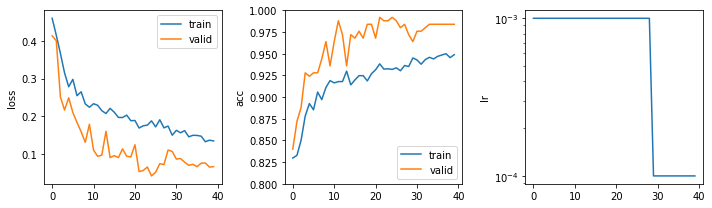

In [ ]:
device = torch.device('cuda')

model = SpamClassifier().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
lrs = []

pbar = tqdm(range(40))
for epoch in pbar:
    # train
    model.train()
    losses = []
    correct = total = 0
    for x, end_idx, y in loader_train:
        x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
        logits = model(x, end_idx)

        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        total += len(x)
    train_loss = np.mean(losses)
    train_acc = correct / total

    # valid
    model.eval()
    losses = []
    correct = total = 0
    for x, end_idx, y in loader_valid:
        x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x, end_idx)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        losses.append(loss.item())
        correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        total += len(x)
    valid_loss = np.mean(losses)
    valid_acc = correct / total

    # sched
    sched.step()
    
    # history
    lrs.append(next(iter(opt.param_groups))['lr'])

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    pbar.set_description(f'loss: {train_loss:.3f}/{valid_loss:.3f}, acc: {train_acc:.2f}/{valid_acc:.2f}')

# plot history
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accuracies, label='train')
axs[1].plot(valid_accuracies, label='valid')
axs[1].set_ylabel('acc')
axs[1].set_ylim(0.8, 1)
axs[1].legend()
axs[2].plot(lrs)
axs[2].set_ylabel('lr')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()

## Bonus - Number sorting
Create and train a NN to sort a sequence of iid standard normally distributed numbers  
Hint: Encoder-Decoder

In [ ]:
class Sorter(nn.Module):
  
    def __init__(self, dh=256, n_lstm_layers=1):
        super().__init__()
        self.dh, self.n_lstm_layers = dh, n_lstm_layers
        self.lin_in = nn.Linear(1, dh)
        self.encoder = nn.LSTM(dh, dh, n_lstm_layers, batch_first=True)
        self.decoder = nn.LSTM(dh, dh, n_lstm_layers, batch_first=True)
        self.lin_out = nn.Linear(dh, 1)
    
    def forward(self, x):
        b, nx, dx = x.shape
        x = self.lin_in(x)  # (b, nx, dh)
        y, (c, h) = self.encoder(x)  # y: (b, nx, dh)
        x = y[:, -1:].expand(-1, nx, -1)  # use the last output of the encoder as the input for the decoder
        y, _ = self.decoder(x, (c, h))  # y: (b, nx, dh)
        return self.lin_out(y)  # (b, nx, 1)

In [ ]:
device = torch.device('cuda')

def train_sorter(nx_range, epochs=20, bs=128, batches_per_epoch=100):
    model = Sorter().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        losses = []
        for _ in range(batches_per_epoch):
            nx = torch.randint(nx_range[0], nx_range[1]+1, (1,))
            x = torch.randn(bs, nx, 1).to(device)
            y = x.sort(dim=1)[0]
            y_hat = model(x)
            
            loss = F.mse_loss(y_hat, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())
        train_loss = np.mean(losses)

        pbar.set_description(f'loss: {train_loss:.3f}')

    return model

nx_range during training (5, 5)


  0%|          | 0/20 [00:00<?, ?it/s]

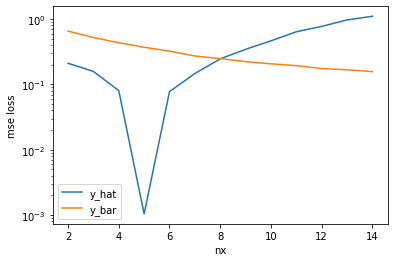

nx_range during training (8, 8)


  0%|          | 0/20 [00:00<?, ?it/s]

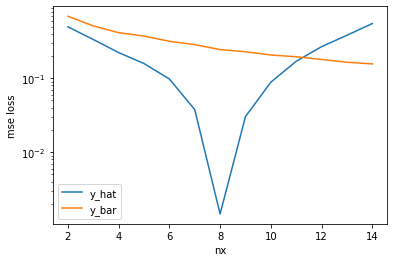

nx_range during training (5, 8)


  0%|          | 0/20 [00:00<?, ?it/s]

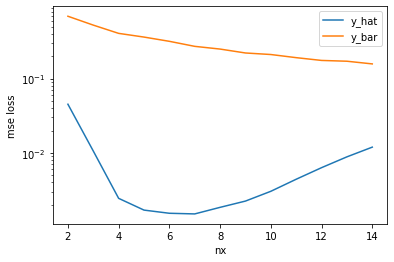

nx_range during training (2, 10)


  0%|          | 0/20 [00:00<?, ?it/s]

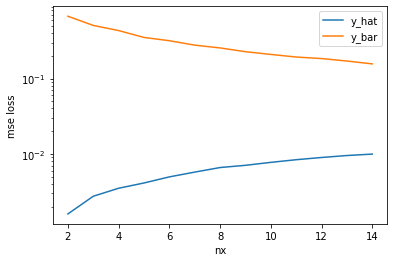

In [ ]:
nxs = np.arange(2, 15)

for nx_range in (5, 5), (8, 8), (5, 8), (2, 10):
    print('nx_range during training', nx_range)
    model = train_sorter(nx_range)

    losses = []
    y_bar_losses = []
    for nx in nxs:
        x_ = torch.randn(2000, nx, 1).to(device)
        y_ = x_.sort(dim=1)[0]

        with torch.no_grad():
            y_hat = model(x_)    
        losses.append(F.mse_loss(y_hat, y_))

        y_bar = y_.mean(0, keepdim=True)
        y_bar_losses.append(F.mse_loss(y_bar.expand_as(y_), y_))
        

    plt.plot(nxs, losses, label='y_hat')
    plt.plot(nxs, y_bar_losses, label='y_bar')
    plt.xlabel('nx')
    plt.ylabel('mse loss')
    plt.yscale('log')
    plt.legend()
    plt.show()